## Step 1. Administration

A bunch of imports. We'll be using
* pandas for file io
* numpy and scipy for fast and easy vector and matrix manipulation
* some python libs (heapq for a priority queue, time for timing queries)
* matplotlib for fancy graphs

In [105]:
import pandas as pd
import numpy as np
from scipy.spatial import kdtree
from scipy.spatial import distance
import heapq
import math
import time
import matplotlib.pyplot as plt
%matplotlib inline  

## Step 2. Read and visualize data

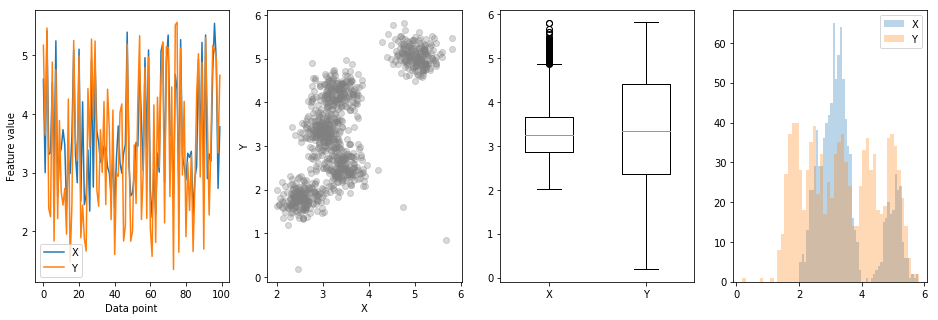

In [106]:
# Read the data from the input file. You may need to change the file path to get this working
data=np.array(pd.read_csv('../data/anomaly.csv',skip_blank_lines=True,header=None))

# Some exploratory plots
fig=plt.figure(facecolor='white',figsize=(16,5))
ax1,ax2,ax3,ax4=fig.subplots(1,4)

ax1.plot(data[0:100,0],label='X')
ax1.plot(data[0:100,1],label='Y')
ax1.set_xlabel('Data point')
ax1.set_ylabel('Feature value')
ax1.legend()

ax2.scatter(data[:,0],data[:,1],color='grey',alpha=0.3)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

ax3.boxplot(data,widths=0.5,labels=['X','Y'])

_=ax4.hist(data[:,0],50,alpha=0.3,label='X')
_=ax4.hist(data[:,1],50,alpha=0.3,label='Y')
ax4.legend()

### Some observations
The two features do not seem to be timeseries (so we can't predict the future features based on history using e.g. LSTMs), yet there seem to exist 5 regimes, each with fairly similar variance characteristics. Covariance in these regimes is very low or zero. Some anomalies seem to be present. A few possible approaches to anomaly detection;
- maybe learn (using a neural network or a mixed linear model) X from Y and Y from X, so we could use (predicted X - X) and (predicted Y -Y) as score for anomalies? Yet there is no apparent local relation between X and Y, so this will be very hard for any regressor.
- we problably need to go the density estimation way, either by assessing local similarity (using k-nearest neighbors) or modeling the data using a mixture of gaussians.

### KNN
- A naive solution, yet attractive because 
    * unsupervised
    * non-parametric
    * easy to implement
    * quantitative rather than qualitative
    
- KNN uses a distance metric to find the closest n neighbors. We can use the average distance to these n-closest neighbors as an anomaly score
    * We need to find the **optimal number of neighbors** to take into account. This could be done if we had a labeled training set (which we have not). 
    * We need a **sensible threshold** to identify a true anomaly. Here we're going to study the distribution of the obtained scores to determine such a threshold.
    * We need to **pick a distance metric**. We're going with the eucledian distance, even though we observe an unequal variance for the feaures. If we knew the regime for each data point or the true range of the values measured, we could rescale the imput data.
    
- There is a **performance concern**: if the input dataset is used as reference (we probably should clean it, remove existing anomalies before scoring additional data), we will need to find the n-closest data points for each assesment. Typically, one would **use an index structure to speed this up** (e.g., quadtrees for 2D or kd-trees for a more flexible solution). As external libraries are off-limits, we will implement a kd-tree from scratch. It allows to find the n-closest neighbors more efficiently (if the number of dimensions is not too high)

### Mixture models
- fit a mixture of gaussians to the observed densities
- can be done using an expectation maximization approach
- after fitting, one can use the posterior probabilities to assess the likelihood that a datapoint was generated by any of the distributions in the mixture model.
- is readily implemented in sklearn, but that library was declared off-limits. As our solution was almost ready (it's just a few lines of code) by the time we came to know this (it really was our go-to solution), we provide a mixture model-based solution for reference at the end of the notebook. 
    

## Step 3. A KD-tree implementation

We took the high-level algorithm description from https://gopalcdas.com/2017/05/24/construction-of-k-d-tree-and-using-it-for-nearest-neighbour-search/ to implement a general (not tailored to two dimensions) kd-tree. With this tree we can find nearest neighbors without having to compare to every data point in the reference set. We use a priority queue (actually a heap) to keep track of the n-closest data points.

In [107]:
#following algorithm description in https://gopalcdas.com/2017/05/24/construction-of-k-d-tree-and-using-it-for-nearest-neighbour-search/
class MyKDTree:
    def __init__(self,data):
        self.__nr,self.__nc=data.shape
        allIndices=np.array(range(self.__nr))
        self.__root=self.__build_tree(data,allIndices,0)
        
    # Build the tree recursively, each time splitting the remaining data according to the median value
    # found in a different dimension. We keep track of the ids of the data points (indices).
    def __build_tree(self,data,real_indices,depth):
        if data.size==0:
            return None
            
        nr,nc=data.shape
        dimension=depth%nc
        
        values_to_sort=data[:,dimension]
        sorted_indices=np.argsort(values_to_sort)
        median_index=nr//2
        
        real_median_index=real_indices[sorted_indices[median_index]]  
        left_selection=sorted_indices[0:median_index]
        right_selection=sorted_indices[median_index+1:]
              
        left=self.__build_tree(data[left_selection,:],real_indices[left_selection],depth+1)  
        right=self.__build_tree(data[right_selection,:],real_indices[right_selection],depth+1)
 
        return (real_median_index,data[sorted_indices[median_index],:],left,right,depth)
    
    # Query the tree to find the closest n neighbors. Here we use a priority queue (a heap) to keep track of 
    # the closes n points during the recursive process
    def query(self,point,n=5):
        if n>self.__nr:
            n==self.__nr
        priority_queue=[]
        for i in range(n):
            heapq.heappush(priority_queue,(math.inf,None))
        self.__query_node(priority_queue,math.inf,point,self.__root,n)
        nearest_neighbors=heapq.nsmallest(n,priority_queue)
        distances=np.zeros(n)
        node_ids=np.zeros(n)
        for i in range(n):
            distances[i]=math.sqrt(nearest_neighbors[i][0])
            node_ids[i]=nearest_neighbors[i][1][0]
            
        return [distances,node_ids]
    
    # The main recursive procedure. 
    def __query_node(self,priority_queue,n_smallest,point,node,n):
        if not node:
            return n_smallest
        node_location = node[1]
        dimension = node[4] % self.__nc
        left = node[2]
        right = node[3]
        distance_to_splitting_plane_sq,is_left_of_split_node = self.__sq_distance_to_splitting_plane(point, node_location, dimension)

        # do left and right? do smallest first
        if distance_to_splitting_plane_sq > n_smallest:
            if  is_left_of_split_node:
                n_smallest = self.__query_node(priority_queue, n_smallest, point, left, n)
            else:
                n_smallest = self.__query_node(priority_queue, n_smallest, point, right, n)
        else:
            distance_to_node_sq = self.__distance_to_node_sq(point, node_location)
            if distance_to_node_sq < n_smallest:
                heapq.heappush(priority_queue, (distance_to_node_sq, node))
                closest_n_neighbors = heapq.nsmallest(n, priority_queue)
                n_smallest = closest_n_neighbors[n - 1][0]

            if is_left_of_split_node:
                n_smallest = self.__query_node(priority_queue, n_smallest, point, left, n)
                n_smallest = self.__query_node(priority_queue, n_smallest, point, right, n)
            else:
                n_smallest = self.__query_node(priority_queue, n_smallest, point, right, n)
                n_smallest = self.__query_node(priority_queue, n_smallest, point, left, n)

        return n_smallest

    @staticmethod
    def __sq_distance_to_splitting_plane(point, node_location, dimension):
        distance = (point[dimension] - node_location[dimension]) ** 2
        is_left = (point[dimension] - node_location[dimension]) < 0
        return distance, is_left
    @staticmethod
    def __distance_to_node_sq(point,node_location):
        return distance.sqeuclidean(point,node_location)
               
    def __str__(self):
        return self.__build_string(self.__root)
    
    def __build_string(self,node):
        if node==None:
            return ''
        rootS= '{} node {} {}\n'.format(' '*node[4]*3,node[0],node[1])
        leftS=self.__build_string(node[2])
        rightS=self.__build_string(node[3])
        return rootS+leftS+rightS

Let's test our implementation, by comparing the underlying tree construction and the search functionality to the reference implementation in scipy.spatial. Data are taken from https://gopalcdas.com/2017/05/24/construction-of-k-d-tree-and-using-it-for-nearest-neighbour-search/.

In [108]:
test_data=np.array([[1, 3], [1, 8], [2, 2], [2, 10], [3, 6], [4, 1], [5, 4], [6, 8], [7, 4], [7, 7], [8, 2], [8, 5], [9, 9] ])
test_tree=MyKDTree(test_data)
scipy_tree=kdtree.KDTree(test_data)
print('Tree layout: \n{}'.format(test_tree))

#test 1000 random points to see if we fnd the same neighbors
for i in range(1000):
    test_point=np.random.rand(2)*10
    nn,node_ids=test_tree.query(test_point,5)
    nn_scipy=scipy_tree.query(test_point,5)
    
    for j in range(5):
        if (np.abs(node_ids-nn_scipy[1])).sum()>0:
            print('Our KD-tree: {}{}'.format(nn,node_ids))
            print('Scipy KD-tree: {}'.format(nn_scipy))


Tree layout: 
 node 6 [5 4]
    node 4 [3 6]
       node 2 [2 2]
          node 0 [1 3]
          node 5 [4 1]
       node 3 [ 2 10]
          node 1 [1 8]
    node 9 [7 7]
       node 10 [8 2]
          node 8 [7 4]
          node 11 [8 5]
       node 12 [9 9]
          node 7 [6 8]



### Step 4. A general neighbor finding class

We implement a method to find the n-closest data points to a point provided by the user. We can choose to use
- a brute force approach, simply comparing the data point with each point in the reference dataset, sorting the obtained distances and returning the n closest points (including the point itself if it was present in the reference dataset)
- the scipy.spatial kd-tree to speed-up the nearest neighbor search
- our own kd-tree implementation

Note that in every approach we don't keep track of the ids of the closest points. This could be easily added, but is not necessary to obtain a score.

In [109]:
class NeighborFinder:
    def __init__(self,data,search_type='brute-force'):
        self.__data=data
        self.__nr,self.__nc=data.shape   
        if search_type=='brute-force':
            self.__search_type=search_type
        elif search_type=='kdtree':
            self.__search_type=search_type
            self.__kdtree=kdtree.KDTree(data)
        elif search_type=='mykdtree':
            self.__search_type=search_type
            self.__kdtree=MyKDTree(data)
        else:
            raise Exception('unknown search type: {}'.format(search_type))
                
    def find_neighbors(self,point,n=5):
        start_t=time.time()
        result=None
        if self.__search_type=='kdtree':
            result=self.__find_from_kdtree(point,n)
        if self.__search_type=='mykdtree':
            result=self.__find_from_mykdtree(point,n)
        elif self.__search_type=='brute-force':
            result=self.__find_brute_force(point,n)
        end_t=time.time()
        query_time=end_t-start_t
        return result,query_time
            
    def __find_from_kdtree(self,point,n):
        distances= self.__kdtree.query(point,n)
        return distances[0]
    
    def __find_from_mykdtree(self,point,n):
        distances,node_ids= self.__kdtree.query(point,n)
        return distances
        
    def __find_brute_force(self,point,n):
        squared_distances=np.zeros(self.__nr)
        for i in range(self.__nr):
            squared_distances[i]=(point[0]-self.__data[i,0])**2+(point[1]-self.__data[i,1])**2
            
        sorted_sq_distances=np.sort(squared_distances)
        return np.sqrt(sorted_sq_distances[0:n])
        

### Step 5. Visualization of the results

Almost there. Here we provide a small function to display the anomalies found in relation to the reference dataset. We also show a distribution of the obtained scores, as a motivation for the score threshold used to identify anomalies.

In [110]:
def create_result_plot(data,score,marker_size,is_anomaly):
    fig=plt.figure(facecolor='white',figsize=(16,5))
    (ax1, ax2) = fig.subplots(1, 2)
    ax1.scatter(data[:, 0], data[:, 1], c='grey',  s=marker_size,marker='o',alpha=0.3);
    ax1.scatter(data[is_anomaly, 0], data[is_anomaly, 1], c='red', s=marker_size[is_anomaly],marker='o',alpha=0.2)
    ax1.scatter(data[is_anomaly, 0], data[is_anomaly, 1], c='red', marker='o',alpha=0.5);
    ax1.set_title('Data')
    _=ax2.hist(score,100)
    ax2.set_title('Score distribution')


### Step 6. Detect anomalies!

(array([0.        , 0.03004084, 0.03661939, 0.04682708, 0.05708185]), 0.0008099079132080078)
total query time = 0.77272s
top scores=[1.9230897  1.05406678 0.97873523]


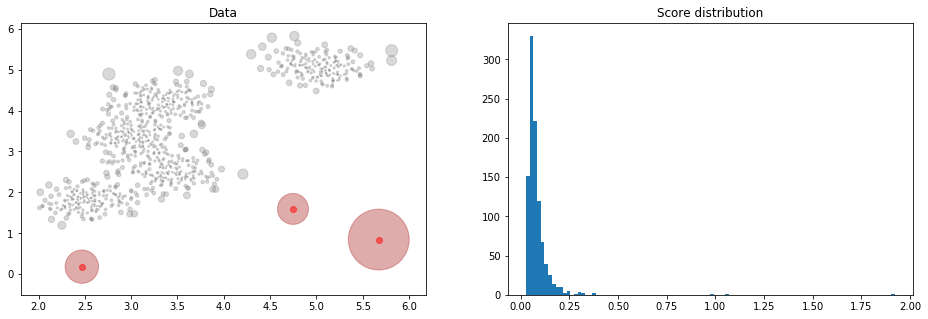

In [120]:
#use our own kd-tree implementation
neighbor_finder=NeighborFinder(data,'mykdtree')
#naive solution, no optimizations at all
#neighbor_finder=NeighborFinder(data,'brute-force')
#use scipy.spatial.kdtree
#neighbor_finder=NeighborFinder(data,'kdtree')

n_neighbors=10 #can be tuned using a labeled dataset, but results are stable for a wide range values

print(neighbor_finder.find_neighbors(data[10,:],5))
nr,nc=data.shape
distances=np.zeros(nr)
index=0
total_time=0
for i in range(nr):
    distance_to_neighbors,query_time=neighbor_finder.find_neighbors(data[i,:],n_neighbors)
    distances[i]=np.mean(distance_to_neighbors)
    total_time+=query_time

print('total query time = {:.5f}s'.format(total_time))
is_anomaly_knn=distances>0.5 #set after observing the distribution of the obtained distances
size = 1000 * distances**2
create_result_plot(data,distances,size,is_anomaly_knn)
print('top scores={}'.format(distances[is_anomaly_knn]))

### Wrapping it up

Using the KNN approach, we can identify three anomalies in the dataset, as is confirmed by visual inspection of the raw data and score distrubution (you have to look closely to see the three tiny bumps in the tail of the distribution). Given that we do not know the underlying regime of the observed features, we can not confidently state whether either feature 1 or feature 2 is abnormal... Our kd-tree implementation is faster than the brute force approach, yet slower than the reference implementation. This is to be expected as we haven't made any optimizations for speed.

We use the detected anomalies to produce a cleaned-up reference set that can be used for future queries.

In [112]:
clean_data=data[is_anomaly_knn==False,:]

df=pd.DataFrame(clean_data)
df.to_csv('../data/clean_data.csv',sep='\t',header=None,index=None)

If we run the detection using cleaned data, we can see that the predictions get (a little bit) stronger for the three previously detected anomalies...

total query time = 0.87753s
top scores=[2.27958055 1.18286431 1.09816484]


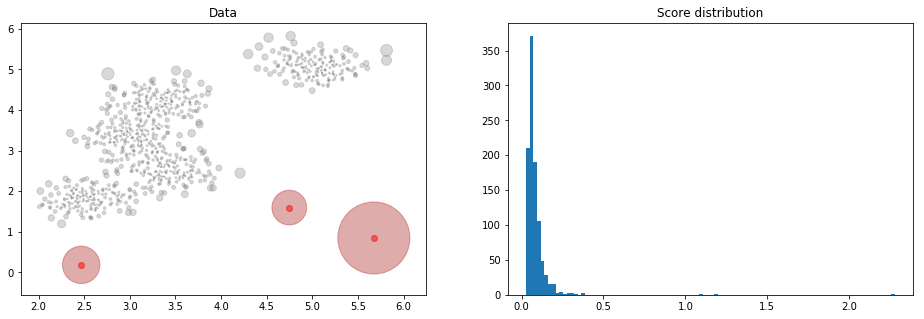

In [113]:
neighbor_finder=NeighborFinder(clean_data,'mykdtree')

n_neighbors=10 #can be tuned using a labeled dataset, but results are stable for a wide range values
nr,_=data.shape
distances=np.zeros(nr)
index=0
total_time=0
for i in range(nr):
    distance_to_neighbors,query_time=neighbor_finder.find_neighbors(data[i,:],n_neighbors)
    distances[i]=np.mean(distance_to_neighbors)
    total_time+=query_time

print('total query time = {:.5f}s'.format(total_time))
is_anomaly_knn=distances>0.5 
size = 1000 * distances**2
create_result_plot(data,distances,size,is_anomaly_knn)
print('top scores={}'.format(distances[is_anomaly_knn]))

### One more thing

For reference, we also provide a solution based on mixture models. We model the data using a mixture of 1..8 gaussians, use the BIC (Bayesian Information Criterion) to select the best model (we could have used AIC too), model the data and use probability densities to assess the likelihood that a data point was generated by the model...

optimal number of components according to BIC = 6


Text(0.5,1,'Best n components')

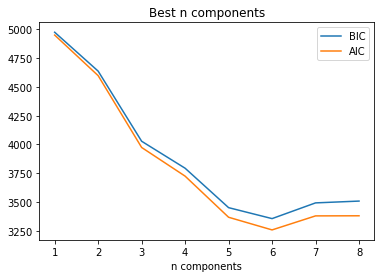

In [114]:
from sklearn.mixture import GaussianMixture 

# Find optimal number of components in mixture
# Note we're using tied covariance matrices, meaning that we assume them to be 
# identical for each component (so just the mean vectors are different)

max_n_components=8
all_BICs=np.zeros(max_n_components)
all_AICs=np.zeros(max_n_components)

for c in range(max_n_components):
    gmm = GaussianMixture(n_components=c+1,covariance_type='tied').fit(data)
    all_BICs[c]=gmm.bic(data)
    all_AICs[c]=gmm.aic(data)
    
bestBIC=np.argsort(all_BICs)[0]
print('optimal number of components according to BIC = {}'.format(bestBIC+1))
plt.figure
plt.plot(range(1,max_n_components+1),all_BICs,label='BIC')
plt.plot(range(1,max_n_components+1),all_AICs,label='AIC')
plt.xticks(range(1,max_n_components+1))
plt.legend(loc='upper right')
plt.xlabel('n components')
plt.title('Best n components')

Now re-run with the optimal number of components. Note that on occasion (due to the random initialization of the EM), results may vary. This can be solved by increasing the number of iterations of the EM, or by seeding the solution using prior knowledge. 

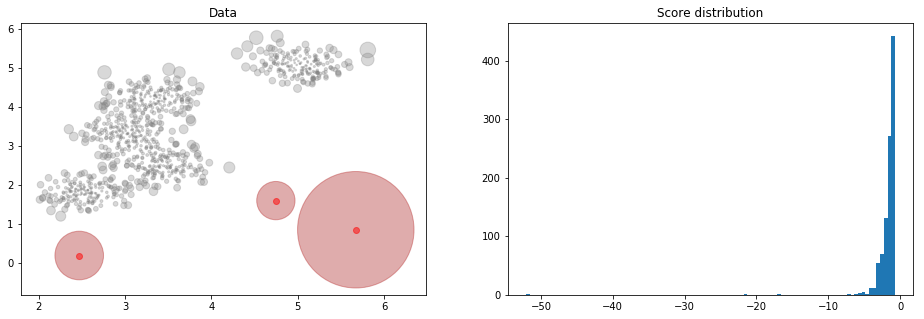

In [115]:
gmm = GaussianMixture(n_components=bestBIC+1,covariance_type='tied').fit(data)
log_prob=gmm.score_samples(data)

is_anomaly_gmm=-log_prob>10
size = 5 * log_prob**2
create_result_plot(data,log_prob,size,is_anomaly_gmm)